In [1]:
import numpy as np
import os
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
import torchvision
from torch.optim import lr_scheduler
import time
import copy
from PIL import Image

In [2]:
class WorksofArt():
    def __init__(self, img_dir='data/resized', transform=None, filter_by_size=False, size_filter=200):
        self.img_dir = img_dir
        self.transform = transform
        self.img_names = os.listdir(img_dir)  # list all images in the folder
        self.img_names.sort()
        self.samples_p_name = self._gen_dict_samples_p_name(self.img_names)
        
        # filter by the size of the samples of each painter
        if filter_by_size:
            keep_list = []
            for artist_name in self.samples_p_name:
                if self.samples_p_name[artist_name] >= size_filter:
                    keep_list.append(artist_name)
                
            img_names_keep = []
            for keep_name in keep_list:
                for i in range(len(self.img_names)):
                    if self.img_names[i].rpartition('_')[0].startswith(keep_name):
                        img_names_keep.append(self.img_names[i])
            self.img_names = img_names_keep
            self.samples_p_name = self._gen_dict_samples_p_name(self.img_names)
        
        self.labels = []
        for idx in range(len(self.img_names)):
            self.labels.append(self.img_names[idx].rpartition('_')[0])
            
        self.img_names = [os.path.join(img_dir, img_name) for img_name in self.img_names]
  
        painter_set = set(self.labels) # set of unique painters names
        self.num_painters = len(painter_set) # number of painters
        
        self.num_to_painter = {i: list(painter_set)[i] for i in range(self.num_painters)} # create a dictionary to map a number to a painter name
        #self.num_to_painter2 = dict(enumerate(painter_set))
        self.painter_to_num = dict(zip(self.num_to_painter.values(), self.num_to_painter.keys())) # create the reverse dictionary to map a painter name to a number
        
        for i in range(len(self.labels)):
            self.labels[i] = self.painter_to_num[self.labels[i]] # Change all label painter names by the respective number
            
    def __len__(self):
        return len(self.img_names)
    
    def _gen_dict_samples_p_name(self, imgs_list):
        unique_names = set([imgs_list[i].rpartition('_')[0] for i in range(len(imgs_list))])
        samples_p_name = {list(unique_names)[i]: 0 for i in range(len(unique_names))}
        # create a dictionary of painter: num samples
        for img in imgs_list:
            artist_name = img.rpartition('_')[0]
            samples_p_name[artist_name] += 1
        return samples_p_name
    
    def __getitem__(self, idx):
        img_name = self.img_names[idx]
        img = Image.open(img_name)#.convert('RGB')
        if(img.mode != 'RGB'):
            img=img.convert('RGB')
            
        label = int(self.labels[idx])
        
        if self.transform:
            img = self.transform(img)
        return img, label
               

In [3]:
# Load dataset
transform = transforms.Compose([
    transforms.Resize((200,200)),
    transforms.ToTensor()])

dataset = WorksofArt(img_dir='data/resized/', transform=transform, filter_by_size=True)


# split dataset
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_data, val_data = torch.utils.data.random_split(dataset, [train_size, val_size]) 

In [4]:
# checking data 
print(type(train_data))
print(train_data[0][0].shape)

<class 'torch.utils.data.dataset.Subset'>
torch.Size([3, 200, 200])


In [5]:
classes = dataset.num_to_painter
print(classes)
print("Num classes (painters): ", len(classes))

{0: 'Albrecht', 1: 'Pierre-Auguste_Renoir', 2: 'Vincent_van_Gogh', 3: 'Edgar_Degas', 4: 'Alfred_Sisley', 5: 'Marc_Chagall', 6: 'Francisco_Goya', 7: 'Pablo_Picasso', 8: 'Rembrandt', 9: 'Titian', 10: 'Paul_Gauguin'}
Num classes (painters):  11


In [6]:
# artworks by painter on the dataset
artworks = dataset.samples_p_name
print(artworks)

{'Albrecht': 328, 'Pierre-Auguste_Renoir': 336, 'Vincent_van_Gogh': 877, 'Edgar_Degas': 702, 'Alfred_Sisley': 259, 'Marc_Chagall': 239, 'Francisco_Goya': 291, 'Pablo_Picasso': 439, 'Rembrandt': 262, 'Titian': 255, 'Paul_Gauguin': 311}


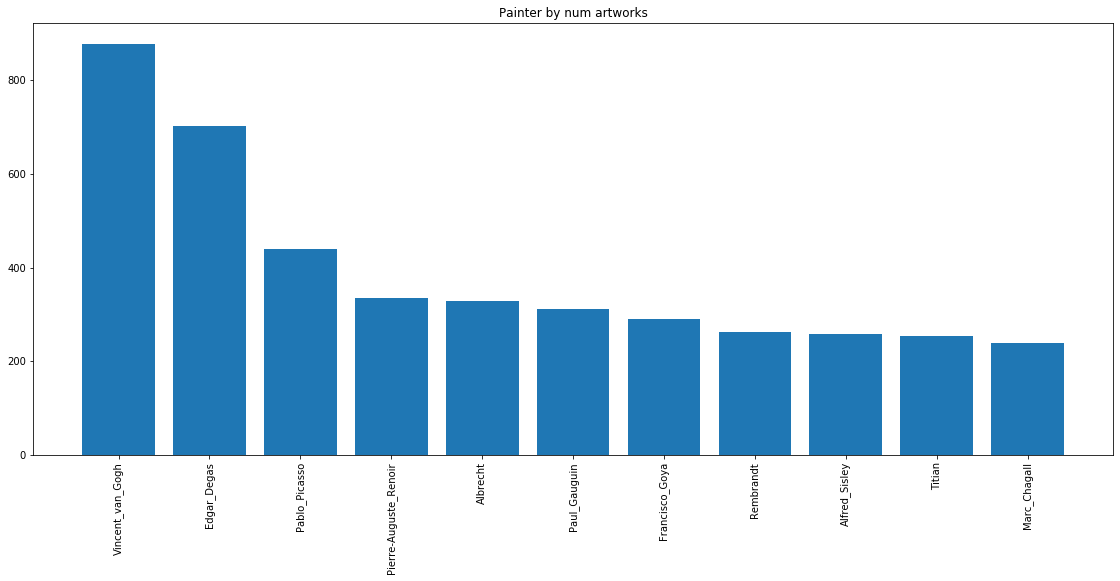

In [7]:
# sort by number of artworks
artworks = {k: v for k, v in sorted(artworks.items(), key=lambda item: item[1], reverse=True)}

fig = plt.figure(figsize=(15,6))
ax = fig.add_axes([0,0,1,1])
ax.bar(artworks.keys(), artworks.values())
plt.title('Painter by num artworks')
plt.xticks(rotation = 90)
plt.show()

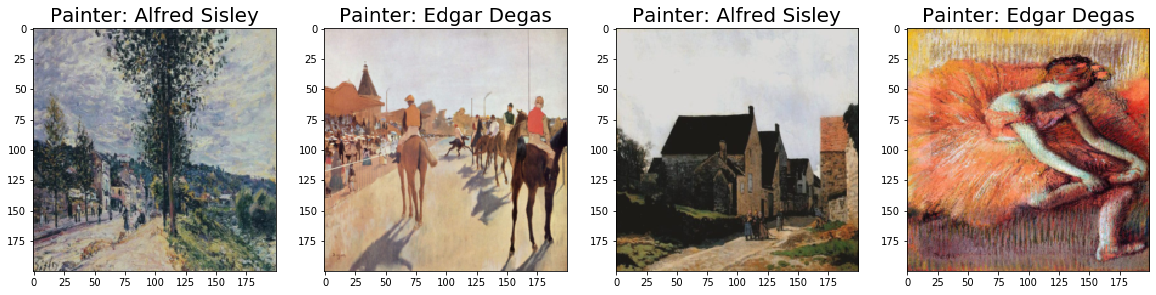

In [8]:
# show a sample of the dataset
transf = transforms.ToPILImage() # create the transform that can be called to convert the tensor into a PIL Image

num_samples = 4

fig, axes = plt.subplots(1, num_samples, figsize=(20,10))

for i in range(num_samples):
    rand_idx = np.random.randint(0, train_size)
    rand_img = train_data[rand_idx][0]
    rand_img = transf(rand_img)    # call the transform on the tensor

    axes[i].imshow(rand_img)
    axes[i].set_title("Painter: " + classes[train_data[rand_idx][1]].replace('_', ' '), fontsize=20)
  
plt.show()

In [9]:
# creating dataloaders
batch_size = 64

# create training data loader
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

# create validation data loader
val_loader = torch.utils.data.DataLoader(dataset=val_data, batch_size=batch_size, shuffle=True)

In [10]:
torch.cuda.empty_cache()
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Using gpu: ", use_cuda)

Using gpu:  True


In [11]:
PATH_state_dict = './artworks.pth' # file to be stored the best weights of the trained model

In [12]:
def train(model, criterion, optimizer, scheduler, epochs=8):
    start_time = time.time()

    best_parameters = copy.deepcopy(model.state_dict())
    best_val_acc = 0.0
    best_epoch = 0
    all_cost_train = []
    all_cost_val = []

    for epoch in range(epochs):
        
        print('Epoch: {}'.format(epoch))
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_loader
                dataset_size = train_size
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = val_loader
                dataset_size = val_size

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad() # reset gradients attribute to zero

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_size
            epoch_acc = running_corrects.double() / dataset_size
            
            if phase == 'train':
                all_cost_train.append(epoch_loss)
            else:
                all_cost_val.append(epoch_loss)

            print('[{}] -> Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_val_acc:
                best_val_acc = epoch_acc
                best_parameters = copy.deepcopy(model.state_dict())
                best_epoch = epoch

        print('-' * 20)

    time_elapsed = time.time() - start_time
    print()
    print('Training completed in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    
    print('Best val Acc: {:4f} , occured in epoch: {}'.format(
        best_val_acc, best_epoch))

    # load best model weights
    model.load_state_dict(best_parameters)
    # save model to file
    torch.save(model.state_dict(), PATH_state_dict)
    
    plt.plot(all_cost_train,label='Train Loss',color='blue')
    plt.plot(all_cost_val,label='Val Loss',color='green')
    plt.title('Overall loss')
    plt.ylabel('Cost')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    
    return model

We're going to apply a pre-trained model of a ResNet-18 (described in https://arxiv.org/pdf/1512.03385.pdf)
Taking advantage of the learned parameters and fine tunning the model. 

In [13]:
learning_rate = 0.0001

# load a pretrained model
ResNet18 = models.resnet18(pretrained=True)

# Change the full-connected layer to have the number of classes we're trying to predict
num_ftrs = ResNet18.fc.in_features
ResNet18.fc = torch.nn.Linear(num_ftrs, len(classes))

ResNet18 = ResNet18.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ResNet18.parameters(), lr=learning_rate, weight_decay=1)

In [14]:
# schedule the learning rate
# step_size: at how many multiples of epoch you decay
# step_size = 1, after every 1 epoch, new_lr = lr*gamma 
# step_size = 2, after every 2 epoch, new_lr = lr*gamma 

# gamma = decaying factor
# Decay LR by a factor of 0.1 every 7 epochs
lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Epoch: 0
[train] -> Loss: 2.0953 Acc: 0.2846
[val] -> Loss: 1.7172 Acc: 0.4395
--------------------
Epoch: 1
[train] -> Loss: 1.4625 Acc: 0.5660
[val] -> Loss: 1.2431 Acc: 0.6628
--------------------
Epoch: 2
[train] -> Loss: 1.0347 Acc: 0.7286
[val] -> Loss: 0.9789 Acc: 0.7605
--------------------
Epoch: 3
[train] -> Loss: 0.7785 Acc: 0.7875
[val] -> Loss: 0.7906 Acc: 0.7860
--------------------
Epoch: 4
[train] -> Loss: 0.6084 Acc: 0.8426
[val] -> Loss: 0.7708 Acc: 0.7628
--------------------
Epoch: 5
[train] -> Loss: 0.5149 Acc: 0.8703
[val] -> Loss: 0.8093 Acc: 0.7372
--------------------
Epoch: 6
[train] -> Loss: 0.4928 Acc: 0.8723
[val] -> Loss: 0.7366 Acc: 0.7884
--------------------
Epoch: 7
[train] -> Loss: 0.3090 Acc: 0.9369
[val] -> Loss: 0.5451 Acc: 0.8302
--------------------
Epoch: 8
[train] -> Loss: 0.2140 Acc: 0.9708
[val] -> Loss: 0.5319 Acc: 0.8558
--------------------
Epoch: 9
[train] -> Loss: 0.1908 Acc: 0.9806
[val] -> Loss: 0.5211 Acc: 0.8581
--------------------


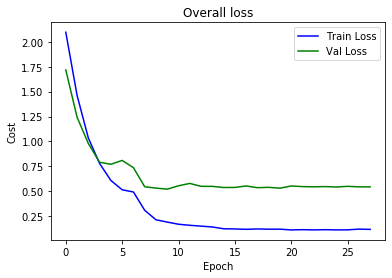

In [15]:
ResNet18 = train(ResNet18, criterion, optimizer, lr_scheduler, epochs=28)

In [20]:
def model_statistics(model, dataloader):
    correct_pred = [0. for i in range(len(classes))]
    total_pred = [0 for i in range(len(classes))]
    running_corrects = 0

    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            #running_corrects += torch.sum(preds == labels.data)
            correct = preds == labels.data
            
            for i in range(len(labels)):
                total_pred[labels[i]] += 1
                if preds[i] == labels.data[i]:
                    correct_pred[labels[i]] += 1
           
        for i in range(len(classes)):
            print('Accuracy of %5s : %2d %%' % (
                classes[i], 100 * correct_pred[i] / total_pred[i]))            
            


In [21]:
model_statistics(ResNet18, val_loader)

Accuracy of Albrecht : 100 %
Accuracy of Pierre-Auguste_Renoir : 81 %
Accuracy of Vincent_van_Gogh : 92 %
Accuracy of Edgar_Degas : 90 %
Accuracy of Alfred_Sisley : 90 %
Accuracy of Marc_Chagall : 91 %
Accuracy of Francisco_Goya : 72 %
Accuracy of Pablo_Picasso : 68 %
Accuracy of Rembrandt : 88 %
Accuracy of Titian : 73 %
Accuracy of Paul_Gauguin : 91 %


In [22]:
model_statistics(ResNet18, train_loader)

Accuracy of Albrecht : 100 %
Accuracy of Pierre-Auguste_Renoir : 100 %
Accuracy of Vincent_van_Gogh : 100 %
Accuracy of Edgar_Degas : 100 %
Accuracy of Alfred_Sisley : 100 %
Accuracy of Marc_Chagall : 99 %
Accuracy of Francisco_Goya : 99 %
Accuracy of Pablo_Picasso : 100 %
Accuracy of Rembrandt : 99 %
Accuracy of Titian : 99 %
Accuracy of Paul_Gauguin : 100 %
